<a href="https://colab.research.google.com/github/Rafifoulol/AMIS_Reseau_Neurones/blob/main/MLP_Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP (Multilayer perceptron)** à 4 couches

## Librairies

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torch.utils.data as data
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Les datasets et valeur globales

Nous récuperons les datasets nécessaire pour l'entrainement ou pour le test. Chacun des datasets est issue de Kaggle. Le premier contient 3096 images d'IRM de patients. Le deuxième contient quand à lui 576 images. Ils ont tous deux 4 catégories d'images :
- Glioma
- Meningioma
- Normal (absence de cancer)
- Pituitary

Et nous initialisons les paramètres globaux :
- La taille final de nos images pour réduire la taille des couches du MLP

In [3]:
path = kagglehub.dataset_download("thomasdubail/brain-tumors-256x256")
#path = kagglehub.dataset_download("vinayjayanti/brain-tumor-mris")

NEW_SIZE = (128, 128)
TYPES= ["Glioma", "Meningioma", "Normal", "Pituitary"]
DATA_PATH = "/root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1/Data"

## Transformation des images et chargement des data pour le MLP

Nous avons séparé le dataset de 3096 images. En faisant 70% des images pour le training et 30% pour le test.

Les images ont été redimensionner en tailles (128x128) pixels, pour réduire la taille de la première couche du MLP mais aussi les suivantes. Pour augmenter l'éfficacité du réseau de neurones. Et enfin pour augmenter la rapidité de calcul.

Les images étant en couleur (RGB) la taille de la 1er couche était multiplié par 3 (3\*128\*128 = 49152), nous avons décidons ne prendre que la couche des gris (même si a première vue elles sont en noir et blanc).


2168
928
torch.Size([197, 1, 128, 128])
torch.Size([64, 1, 128, 128])


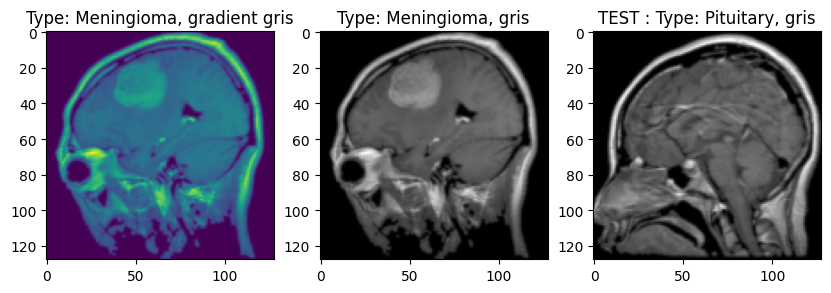

In [16]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(NEW_SIZE),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)

train_size = int(0.7 * len(full_dataset)) +1
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=197, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

print(len(train_dataset))
print(len(test_dataset))

image, label = next(iter(train_data_loader))
print(image.shape)

i, l = next(iter(test_data_loader))
print(i.shape)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(image[0].squeeze())
plt.title(f"Type: {TYPES[label[0]]}, gradient gris")

plt.subplot(1, 3, 2)
plt.imshow(image[0].squeeze(), cmap='gray')
plt.title(f"Type: {TYPES[label[0]]}, gris")

plt.subplot(1, 3, 3)
plt.imshow(i[0].squeeze(), cmap='gray')
plt.title(f"TEST : Type: {TYPES[l[0]]}, gris")
plt.show()

## Création du MLP

Comme précisé avant la taille d'une image est maintenant 128x128 pixels. La forme des donné dans le réseau de neurones est de la forme :

```
torch.Size([129, 1, 128, 128])
```

La première couche étant la taille d'une image applatit en vecteur ligne, ça taille est : 1 \* 128 \* 128 = 16384
Notre output doit être de taille 4, puisqu'il a 4 catégorie possibles.
Les couches internes sont donc de taille 4096 et 512 pour essayer d'affinit le résultat le plus possibles sans réduire drastiquement la taille des entrées/sorties des couches.




In [5]:
class MLP(nn.Module) :
  def __init__(self, input_size=16384, output_size=4, layers=[4096, 512]):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(input_size, layers[0]))
    self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(layers[0], layers[1]))
    self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(layers[1], output_size))

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

## Initialisation du MLP, de la fonction de Loss et des poids du réseau de neurones

In [6]:
mlp = MLP()
print(mlp.eval())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=16384, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)


## Vérification de la taille des images et des Bacth

In [9]:
for images, labels in train_data_loader:
  print(images.shape)
  print(labels.shape)
  break
print("Batch shape after flattening : ", images.view(197, -1).size())

torch.Size([197, 1, 128, 128])
torch.Size([197])
Batch shape after flattening :  torch.Size([197, 16384])


## Entrainement du réseau de neurones

On configure avec ```torch.device```, en permettant l'utilisation du GPU (CUDA) si disponible, ou sinon, le CPU. On transfert le modèle (mlp) sur ce dispositif pour accélérer les calculs.

À chaque itération, les images et les labels sont transférés sur l'appareil (GPU/CPU) et les images sont aplaties pour correspondre à l'entrée du MLP. Le modèle effectue une prédiction (`y_pred`), puis la perte entre les prédictions et les labels réels est calculée avec la fonction `criterion` (ici, `nn.CrossEntropyLoss`).

Les gradients sont réinitialisés avec `optimizer.zero_grad()`, la back propagation est exécutée avec `loss.backward()`, et les paramètres du modèle sont mis à jour avec `optimizer.step()`.

Les précisions et pertes cumulées pour chaque époque sont stockées dans les listes train_accuracies_list et train_losses_list. Et on affiche le résultat une fois l'epoch finit pour le 24 Bach (3096 / 129 = 24)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
mlp = mlp.to(device)

epochs = 10
train_loses = []
test_loses = []
train_corrects = []
test_corrects = []


train_losses_list = []
test_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

for epoch in range(epochs):
  train_correct = 0
  test_correct = 0

  train_accuracy = 100 * train_correct / len(train_dataset)
  train_accuracies_list.append(train_accuracy)
  train_losses_list.append(0)

  for b, (images, labels) in enumerate(train_data_loader):
    b += 1

    images = images.to(device)
    labels = labels.to(device)

    y_pred = mlp(images.view(images.size(0), -1))
    loss = criterion(y_pred, labels)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_correct = (predicted == labels).sum()
    train_correct += batch_correct

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_accuracies_list[-1] = 100 * train_correct / len(train_dataset)
    train_losses_list[-1] = loss.cpu().item()

    #print(f'Epoch [{epoch + 1}/{epochs}], Bach [{b}/{len(train_data_loader)}], '
    #     f'Accuracy: {100 * batch_correct / images.size(0):.2f}%')
  print(f'Epoch [{epoch + 1}/{epochs}], '
        f'Accuracy: {100 * train_correct / len(train_dataset):.2f}%')
train_loses.append(loss.cpu().item())
train_corrects.append(train_correct.cpu().item())


cpu
Epoch [1/10], Accuracy: 27.17%
Epoch [2/10], Accuracy: 28.04%
Epoch [3/10], Accuracy: 37.45%
Epoch [4/10], Accuracy: 39.25%
Epoch [5/10], Accuracy: 47.69%
Epoch [6/10], Accuracy: 44.60%
Epoch [7/10], Accuracy: 51.11%
Epoch [8/10], Accuracy: 61.16%
Epoch [9/10], Accuracy: 61.72%
Epoch [10/10], Accuracy: 59.13%


# Testing

Dans ce code, nous évaluons les performances de notre modèle MLP sur les données de test en utilisant torch.no_grad() pour désactiver le calcul des gradients.

La perte est calculée à l’aide de `criterion` (`CrossEntropyLoss`), et la précision est déterminée en comparant les prédictions du modèle aux labels réels. À chaque étape, nous stockons la perte et la précision dans des listes (`test_losses_list`, `test_accuracies_list`) et affichons les résultats par batch.

 À la fin, nous mettons à jour les métriques globales, notamment la dernière perte et le total des prédictions correctes, dans `test_loses` et `test_corrects`.


In [17]:
with torch.no_grad():

  test_losses_list = []
  test_accuracies_list = []
  test_correct = 0

  for b, (images, labels) in enumerate(test_data_loader):

    images = images.to(device)
    labels = labels.to(device)

    y_val = mlp(images.view(images.size(0), -1))
    loss = criterion(y_val, labels)
    predicted = torch.max(y_val.data, 1)[1]
    test_correct += (predicted == labels).sum()

    test_accuracies_list.append(100 * (predicted == labels).sum() / images.size(0))
    test_losses_list.append(loss.cpu().item())

    print(f'Testing Bach [{b + 1}/{len(test_data_loader)}], '
          f'Accuracy: {100 * (predicted == labels).sum() / images.size(0):.2f}%, '
          f'Loss: {loss.item():.4f}')

test_loses.append(loss.cpu().item())
test_corrects.append(test_correct.cpu().item())

Testing Bach [1/15], Accuracy: 75.00%, Loss: 0.7548
Testing Bach [2/15], Accuracy: 75.00%, Loss: 0.8147
Testing Bach [3/15], Accuracy: 67.19%, Loss: 0.8589
Testing Bach [4/15], Accuracy: 73.44%, Loss: 0.7302
Testing Bach [5/15], Accuracy: 62.50%, Loss: 0.7877
Testing Bach [6/15], Accuracy: 65.62%, Loss: 0.8185
Testing Bach [7/15], Accuracy: 70.31%, Loss: 0.8415
Testing Bach [8/15], Accuracy: 67.19%, Loss: 0.8634
Testing Bach [9/15], Accuracy: 75.00%, Loss: 0.7835
Testing Bach [10/15], Accuracy: 67.19%, Loss: 0.8249
Testing Bach [11/15], Accuracy: 57.81%, Loss: 0.9480
Testing Bach [12/15], Accuracy: 71.88%, Loss: 0.7840
Testing Bach [13/15], Accuracy: 53.12%, Loss: 0.9306
Testing Bach [14/15], Accuracy: 75.00%, Loss: 0.8501
Testing Bach [15/15], Accuracy: 81.25%, Loss: 0.7042


## Transformation des résultats

In [18]:
train_accuracies_list = [x.cpu() if torch.is_tensor(x) else x for x in train_accuracies_list]
train_losses_list = [x.cpu() if torch.is_tensor(x) else x for x in train_losses_list]
test_accuracies_list = [x.cpu() if torch.is_tensor(x) else x for x in test_accuracies_list]
test_losses_list = [x.cpu() if torch.is_tensor(x) else x for x in test_losses_list]

## Affichage de la courbe de la précision en fonction des epochs (et batch)


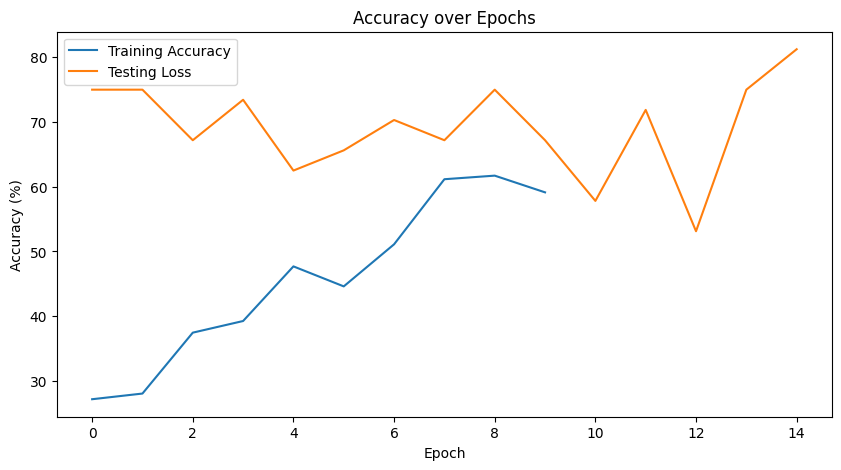

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_list, label='Training Accuracy')
plt.plot(test_accuracies_list, label='Testing Loss')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Affichage de la Loss par epoch

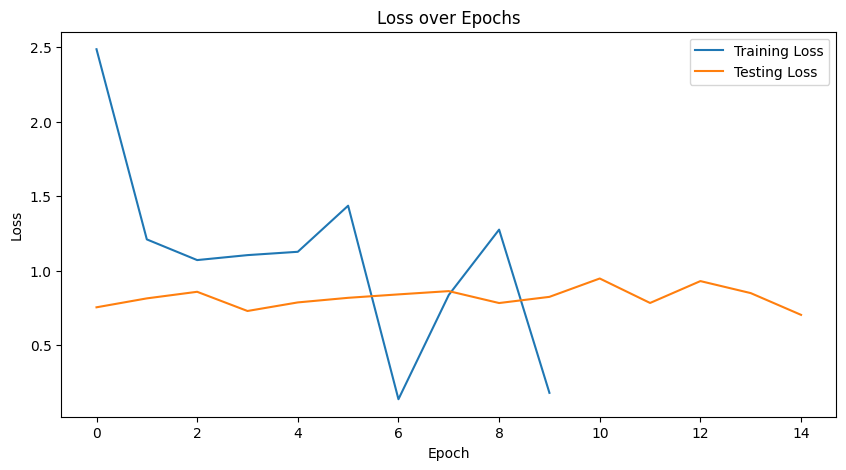

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_list, label='Training Loss')
plt.plot(test_losses_list, label='Testing Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Sauvegarde du modèle

In [ ]:
PATH = "mlp_model.pth"

torch.save(mlp.state_dict(), PATH)

print(f"Model parameters saved to {PATH}")
!ls -la # /content/drive/mlp_model.pth

Model parameters saved to mlp_model.pth
total 270392
drwxr-xr-x 1 root root      4096 Jan  9 14:08 .
drwxr-xr-x 1 root root      4096 Jan  9 12:42 ..
drwxr-xr-x 4 root root      4096 Jan  7 14:21 .config
drwx------ 6 root root      4096 Jan  9 12:46 drive
-rw-r--r-- 1 root root 276853468 Jan  9 14:18 mlp_model.pth
drwxr-xr-x 1 root root      4096 Jan  7 14:22 sample_data


## Téléchargement du modèle prés entrainé

In [ ]:
from google.colab import files
files.download('mlp_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>